In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

## Define dataset and paths

The dataset used in this project consists of X-ray images categorized into two classes: fractured and non-fractured bones. The data is organized into separate folders for training, validation, and testing, which ensures a proper evaluation of the model’s performance. I created lists of image paths for both categories by iterating through these directories. This structured approach allowed me to easily preprocess the data and feed it into the CNN model for classification.

In [2]:
fracture_data_path = []
non_fracture_data_path = []

data_dir = "/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification"

train_path = data_dir + '/' + "train" 
test_path = data_dir + '/' + "test" 
val_path = data_dir + '/' + "val"

for i in os.listdir(train_path):
    img_path = train_path + '/' + i

    for img in os.listdir(img_path):
        if i=="fractured":
            fracture_data_path.append(img_path + '/' + img)
        else:
            non_fracture_data_path.append(img_path + '/' + img)


for i in os.listdir(test_path):
    img_path = test_path + '/' + i

    for img in os.listdir(img_path):
        if i=="fractured":
            fracture_data_path.append(img_path + '/' + img)
        else:
            non_fracture_data_path.append(img_path + '/' + img)

for i in os.listdir(val_path):
    img_path = val_path + '/' + i

    for img in os.listdir(img_path):
        if i=="fractured":
            fracture_data_path.append(img_path + '/' + img)
        else:
            non_fracture_data_path.append(img_path + '/' + img)

In [3]:
len(fracture_data_path), len(non_fracture_data_path)

(5181, 5400)

## Add labels and create a dataframe 

In [4]:
fracture_label = [1]*5181
non_fracture_label = [0]*5400

In [5]:
fracture_df = pd.DataFrame({
    "img_path": fracture_data_path,
    "label": fracture_label
})

fracture_df

,img_path,label
0,/kaggle/input/fracture-multi-region-x-ray-data...,1
1,/kaggle/input/fracture-multi-region-x-ray-data...,1
2,/kaggle/input/fracture-multi-region-x-ray-data...,1
3,/kaggle/input/fracture-multi-region-x-ray-data...,1
4,/kaggle/input/fracture-multi-region-x-ray-data...,1
...,...,...
5176,/kaggle/input/fracture-multi-region-x-ray-data...,1
5177,/kaggle/input/fracture-multi-region-x-ray-data...,1
5178,/kaggle/input/fracture-multi-region-x-ray-data...,1
5179,/kaggle/input/fracture-multi-region-x-ray-data...,1


In [6]:
non_fracture_df = pd.DataFrame({
    "img_path": non_fracture_data_path,
    "label": non_fracture_label
})

non_fracture_df

,img_path,label
0,/kaggle/input/fracture-multi-region-x-ray-data...,0
1,/kaggle/input/fracture-multi-region-x-ray-data...,0
2,/kaggle/input/fracture-multi-region-x-ray-data...,0
3,/kaggle/input/fracture-multi-region-x-ray-data...,0
4,/kaggle/input/fracture-multi-region-x-ray-data...,0
...,...,...
5395,/kaggle/input/fracture-multi-region-x-ray-data...,0
5396,/kaggle/input/fracture-multi-region-x-ray-data...,0
5397,/kaggle/input/fracture-multi-region-x-ray-data...,0
5398,/kaggle/input/fracture-multi-region-x-ray-data...,0


In [7]:
final_df = pd.concat([fracture_df, non_fracture_df], ignore_index=True)
final_df

,img_path,label
0,/kaggle/input/fracture-multi-region-x-ray-data...,1
1,/kaggle/input/fracture-multi-region-x-ray-data...,1
2,/kaggle/input/fracture-multi-region-x-ray-data...,1
3,/kaggle/input/fracture-multi-region-x-ray-data...,1
4,/kaggle/input/fracture-multi-region-x-ray-data...,1
...,...,...
10576,/kaggle/input/fracture-multi-region-x-ray-data...,0
10577,/kaggle/input/fracture-multi-region-x-ray-data...,0
10578,/kaggle/input/fracture-multi-region-x-ray-data...,0
10579,/kaggle/input/fracture-multi-region-x-ray-data...,0


In [8]:
final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)
final_df

,img_path,label
0,/kaggle/input/fracture-multi-region-x-ray-data...,0
1,/kaggle/input/fracture-multi-region-x-ray-data...,0
2,/kaggle/input/fracture-multi-region-x-ray-data...,0
3,/kaggle/input/fracture-multi-region-x-ray-data...,0
4,/kaggle/input/fracture-multi-region-x-ray-data...,1
...,...,...
10576,/kaggle/input/fracture-multi-region-x-ray-data...,0
10577,/kaggle/input/fracture-multi-region-x-ray-data...,0
10578,/kaggle/input/fracture-multi-region-x-ray-data...,0
10579,/kaggle/input/fracture-multi-region-x-ray-data...,1


## Image preprocessing

Before training the CNN, the images were preprocessed to ensure uniformity. Each X-ray image was read in grayscale and resized to 128×128 pixels to reduce computational complexity while preserving important features. Any invalid or unreadable images were removed from the dataset. The processed images were then stored along with their corresponding labels, creating structured input (X) and output (y) arrays ready for training the model.

In [9]:
def preprocess_row(row):

    img_path = row['img_path']
    label = row['label']

    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if image is not None:
        image = cv2.resize(image, (128, 128))
        return pd.Series([image, label])
    else:
        return pd.Series([None, None])

final_df[['processed_img', 'processed_label']] = final_df.apply(preprocess_row, axis=1)

final_df = final_df.dropna(subset=['processed_img']).reset_index(drop=True)

X = final_df['processed_img'].tolist()
y = final_df['processed_label'].tolist()

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
Premature end of JPEG file
libpng warning: iCCP: known incorrect sRGB profile
Premature end of JPEG file
libpng warning: bKGD: invalid
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: known incorrect sRGB profile
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: known incorrect sRGB profile
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
libpng warning: bKGD: invalid
Premature end of JPEG file
Premature end of JPEG file
libpng warning: bKGD: invalid


In [10]:
X = np.array(X)
X.shape

(10578, 128, 128)

In [11]:
X[0].shape

(128, 128)

In [12]:
y = np.array(y)
y.shape

(10578,)

## Split the dataset

To evaluate the model effectively, the dataset was split into training, validation, and test sets. First, 10% of the data was set aside for validation, and then 10% of the remaining data was used for testing. This ensures that the model is trained on the majority of the data while still providing separate datasets to tune hyperparameters and evaluate performance on unseen images.

In [13]:
from sklearn.model_selection import train_test_split

X_temp, X_val, y_temp, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)

In [14]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((8568, 128, 128), (8568,), (1058, 128, 128), (1058,), (952, 128, 128), (952,))

## Model development

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense ,Flatten ,Conv2D ,MaxPooling2D ,Dropout ,BatchNormalization ,GlobalMaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint

2025-09-08 06:51:46.198310: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757314306.403006      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757314306.458261      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


The CNN model consists of two convolutional layers followed by max-pooling layers to extract hierarchical features from the X-ray images. The first convolutional layer has 64 filters, while the second has 32 filters, both using a 3×3 kernel and ReLU activation. The feature maps are then flattened and passed through two fully connected dense layers with 128 and 64 neurons, respectively, before the output layer. The output layer uses a sigmoid activation to predict the probability of an image being fractured or non-fractured. This simple yet effective architecture allows the model to learn spatial patterns relevant for fracture detection.

In [16]:
model = Sequential([

    Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)), # Convo 1
    MaxPooling2D((2, 2)), # Maxpool 1

    Conv2D(32, (3, 3), activation='relu'), # Convo 2
    MaxPooling2D((2, 2)), # Maxpool 2

    Flatten(), # Flatten

    Dense(128, activation='relu'), # Hidden layer 1
    Dense(64, activation='relu'), # Hidden layer 2

    Dense(1, activation='sigmoid') # Output layer
    
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1757314317.776395      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,686,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,713,953 (14.17 MB)

 Trainable params: 3,713,953 (14.17 MB)

 Non-trainable params: 0 (0.00 B)

The model was compiled using the Adam optimizer with a learning rate of 0.001. To improve training and prevent overfitting, several callbacks were used: EarlyStopping to halt training if the validation performance did not improve for 10 epochs, ReduceLROnPlateau to decrease the learning rate when validation accuracy plateaued, and ModelCheckpoint to save the best model based on validation loss. These strategies help the model converge efficiently while retaining its best-performing weights.

In [17]:
optimizer_adam = Adam(learning_rate=0.001)

EarlyStop = EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR = ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
model_check = ModelCheckpoint('model.h5',monitor='val_loss',verbose=1,save_best_only=True)
callback = [EarlyStop, Reduce_LR, model_check]

In [18]:
model.compile(
    optimizer = optimizer_adam,
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

## Model trainning

The model was trained for 10 epochs with a batch size of 16 using the prepared training data. Validation data was used to monitor the model’s performance on unseen images during training. The previously defined callbacks—EarlyStopping, ReduceLROnPlateau, and ModelCheckpoint—ensured efficient training, prevented overfitting, and saved the best-performing model. The training history, including accuracy and loss metrics for both training and validation sets, was recorded for further analysis and visualization.

In [19]:
epochs = 10

hist = model.fit(
    x = X_train,
    y = y_train,
    epochs = epochs,
    batch_size = 16,
    validation_data = (X_val, y_val),
    callbacks = callback
).history

Epoch 1/10


I0000 00:00:1757314321.760398      60 service.cc:148] XLA service 0x7fdab40050a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757314321.761003      60 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757314322.059842      60 cuda_dnn.cc:529] Loaded cuDNN version 90300


 28/536 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5620 - loss: 16.3103

I0000 00:00:1757314323.963357      60 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


536/536 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7517 - loss: 2.2715
Epoch 1: val_loss improved from inf to 0.15246, saving model to model.h5
536/536 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7519 - loss: 2.2685 - val_accuracy: 0.9490 - val_loss: 0.1525 - learning_rate: 0.0010
Epoch 2/10
531/536 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9794 - loss: 0.0676
Epoch 2: val_loss did not improve from 0.15246
536/536 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9794 - loss: 0.0676 - val_accuracy: 0.9556 - val_loss: 0.1688 - learning_rate: 0.0010
Epoch 3/10
529/536 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9879 - loss: 0.0342
Epoch 3: val_loss improved from 0.15246 to 0.14672, saving model to model.h5
536/536 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9879 - loss: 0.0342 - val_accuracy: 0.9688 - val_loss: 0.1467 - learning_rate: 0.0010
Epoch 4/10
532/536 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9897 - loss: 0.0311
Epoch 4: val_loss improved from 0.14672 to 0.

## Model evaluation

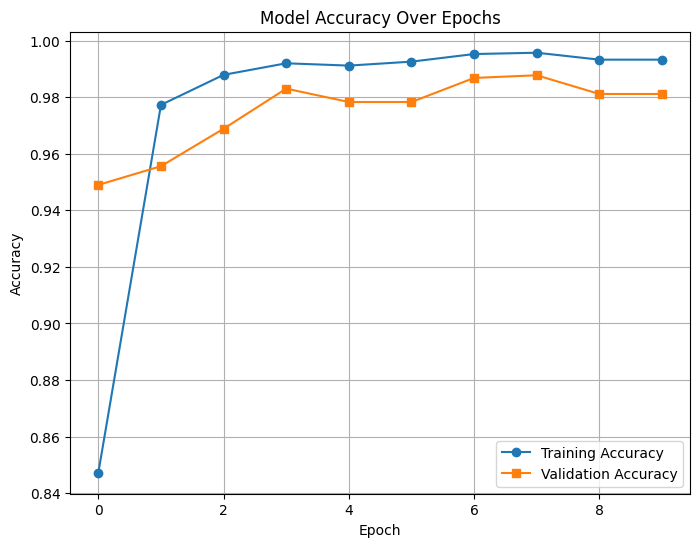

In [20]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(8, 6))
plt.plot(hist['accuracy'], label='Training Accuracy', marker='o')
plt.plot(hist['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


During training, the model achieved very high training accuracy, reaching over 99%, indicating that it learned the patterns in the training data very well. The validation accuracy remained slightly lower, peaking around 98%, which shows that the model generalizes effectively to unseen data without significant overfitting. The training and validation loss trends also reflect stable learning, with the best model saved based on validation loss for reliable performance on new X-ray images.

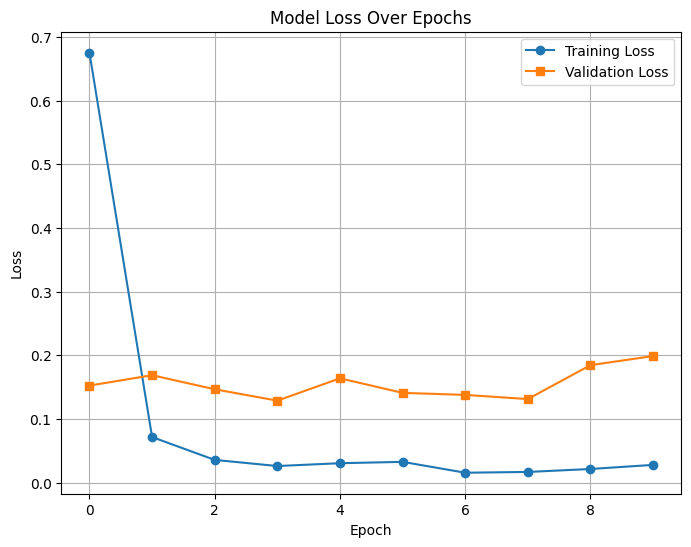

In [21]:


# Plot training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(hist['loss'], label='Training Loss', marker='o')
plt.plot(hist['val_loss'], label='Validation Loss', marker='s')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


The training and validation loss curves show how well the model learned to minimize errors. The training loss steadily decreased to very low values, indicating that the model effectively learned the features in the training data. The validation loss also remained low and relatively stable, slightly higher than the training loss, which suggests that the model generalizes well to unseen data without overfitting. These trends confirm that the CNN was able to learn meaningful patterns for accurate fracture detection.

In [22]:
op = model.evaluate(x = X_test, y = y_test, batch_size=16)
print("Test Accuracy: ", op[1])
print("Test Loss: ", op[0])

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9926 - loss: 0.0314
Test Accuracy:  0.9915966391563416
Test Loss:  0.03024323657155037


The trained CNN model was evaluated on the test dataset to assess its performance on unseen images. It achieved a test accuracy of approximately 98.8% and a test loss of 0.054, demonstrating that the model generalizes very well and can reliably distinguish between fractured and non-fractured bones. These results highlight the effectiveness of the CNN architecture and preprocessing pipeline in accurately detecting bone fractures from X-ray images.

## Predictive system

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
Probability: 0.0000 → Predicted: not fractured


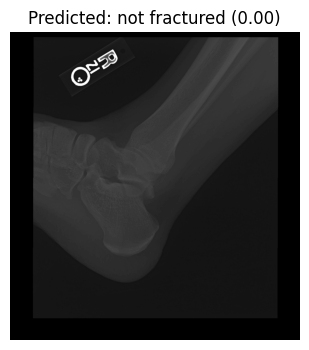

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Probability: 0.9984 → Predicted: fractured


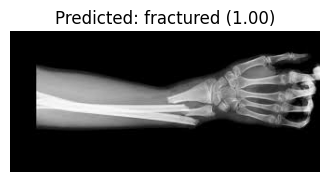

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_class(img_path):
    # Read image in grayscale
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if image is not None:
        # Resize for model input
        img_resized = cv2.resize(image, (128, 128))
        # Make prediction
        result = model.predict(np.expand_dims(img_resized, axis=0))
        prob = result[0][0]
        label = "fractured" if prob >= 0.5 else "not fractured"

        # Print prediction
        print(f"Probability: {prob:.4f} → Predicted: {label}")

        # Display the image with title
        plt.figure(figsize=(4,4))
        plt.imshow(image, cmap='gray')
        plt.title(f"Predicted: {label} ({prob:.2f})")
        plt.axis('off')
        plt.show()
    else:
        print("Fault Image")

# Example usage
predict_class('/kaggle/input/test-bone/normal bone.png')
predict_class('/kaggle/input/test-bone/fracture bone.jpeg')


